In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:
from architectures.architectures import MLP

from flax import nnx
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array

In [3]:
index = 3
device = jax.devices()[index] if jax.devices() else jax.devices('cpu')[0] # If only one gpu change index to 0
print(f"Selected device: {device}")

Selected device: cuda:3


# NODE setup

In [4]:
from architectures.node import NeuralODE

In [5]:
key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)
model = MLP(din=2, num_layers=3, width_layers=128, dout=2, activation_fn="tanh", rngs=nnx.Rngs(0))
node = NeuralODE(
    dynamics_model=model,
    time_dependent=False,
    dt0=0.1,
    rtol=1e-4,
    atol=1e-6
)

# Initial condition
y0 = jnp.array([1.0, 0.5])

# Solve from t=0 to t=1
y_final = node(y0, (0.0, 1.0))
print("Final state:", y_final)

Final state: [[0.95567995 0.4358569 ]]


# G Mat

In [6]:
from geometry.G_matrix import G_matrix

In [7]:
G_mat = G_matrix(node)

In [8]:
# # Test
# key = jax.random.PRNGKey(0)
# rngs = nnx.Rngs(key)

# n_samples = 100_000
# d = 2
# z_samples = jax.random.normal(key,(n_samples,d))

# z_samples = jax.device_put(z_samples,device)


In [9]:
# _,params = nnx.split(node)
# key,subkey = jax.random.split(key)
# eta = jax.tree.map(lambda p:jax.random.normal(subkey, p.shape)*10, params) #   jax.numpy.ones(p.shape)
# eta = jax.tree.map(lambda p: jax.device_put(p,device), eta)
# key,subkey = jax.random.split(key)
# epsilon = jax.tree.map(lambda p: jax.random.normal(subkey, p.shape)*0.1, params)
# eta_pert = jax.tree.map(lambda e,ep: e+ep, eta, epsilon)

In [10]:
# # Compute G_hat@eta
# result = G_mat.mvp(z_samples, eta)

In [11]:
# key,subkey = jax.random.split(key)
# z_samples = jax.random.normal(subkey,(n_samples,d))
# z_samples = jax.device_put(z_samples,device)

# # Test solver 
# result_solver, _ = G_mat.solve_system(z_samples, result, tol=1e-6, maxiter=20,x0 = eta_pert, method="minres")

In [12]:
# jax.tree.map(lambda x,y: jnp.linalg.norm(x-y)/jnp.linalg.norm(y), result_solver, eta)

In [13]:
# verify_result = G_mat.mvp(z_samples, result_solver)
# jax.tree.leaves(jax.tree.map(lambda x,y: jnp.linalg.norm(x-y)/jnp.linalg.norm(y), result, verify_result))

# Gradient flow test

# General form

In [14]:
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential

In [15]:
from flows.gradient_flow import run_gradient_flow
from flows.visualization import visualize_gradient_flow_results

In [16]:
# Create potentials
potentials = create_potentials()

In [25]:
# Gradient flow parameters
h = 1e-2 # Time step size
max_iterations = 100
tolerance = 1e-6
n_samples = 4_000  # Monte Carlo sample size


key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)

# Create NODE model
gradient_flow_model = MLP(din=2, num_layers=1, width_layers=32, dout=2, 
                         activation_fn="tanh", rngs=rngs)
gradient_flow_node = NeuralODE(
    dynamics_model=gradient_flow_model,
    time_dependent=False,
    dt0=0.1,
)

# Set parameters to be very small (near zero)
_, initial_params = nnx.split(gradient_flow_node)
scale_factor = 1e-2  # Small scaling to keep near identity

# Scale all parameters to be small
small_params = jax.tree.map(lambda p: p * scale_factor, initial_params)

# Merge back into the node
graphdef, _ = nnx.split(gradient_flow_node)
gradient_flow_node = nnx.merge(graphdef, small_params)

# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

G_mat_flow = G_matrix(gradient_flow_node)

potential = potentials['strong_double_well'] # Options: quadratic, double_well, strong_double_well,quartic
solver= 'minres'


Starting gradient flow with LinearPotential...
Potential function: double_well_potential_fn
Potential parameters: {'alpha': 5.0}
Selected device: cuda:0
Initial energy: 8.136963
Target: minimize energy functional
Iter   0: Energy = 8.174459, Decrease = -0.037497, Grad norm: 2.31e-01


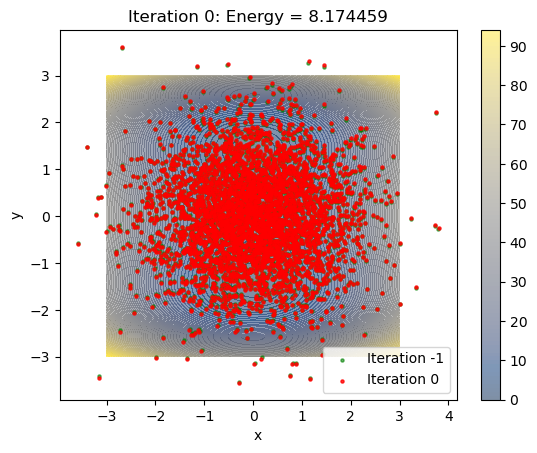

Iter  10: Energy = 2.843426, Decrease = 5.293537, Grad norm: 5.92e+00


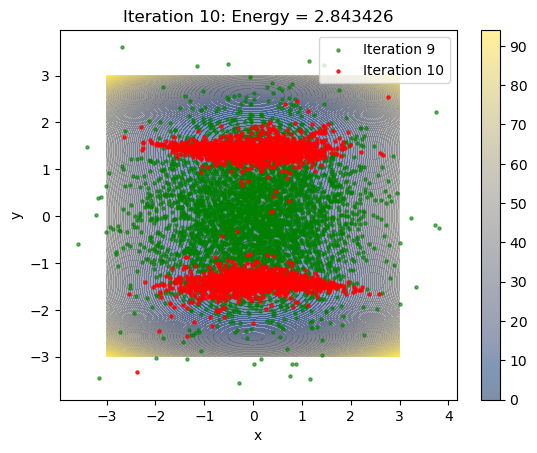

Iter  20: Energy = 2.199028, Decrease = 5.937935, Grad norm: 4.12e+00


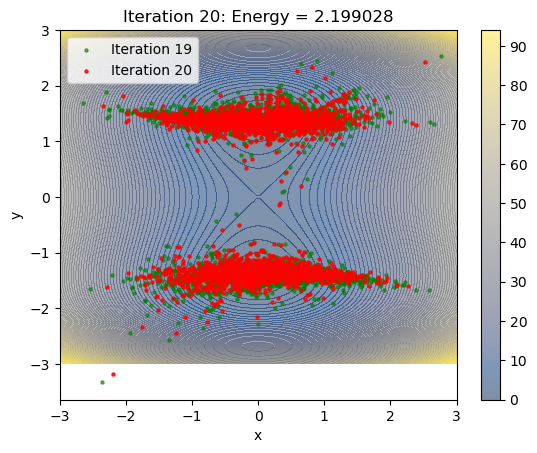

Iter  30: Energy = 1.903316, Decrease = 6.233647, Grad norm: 3.69e+00


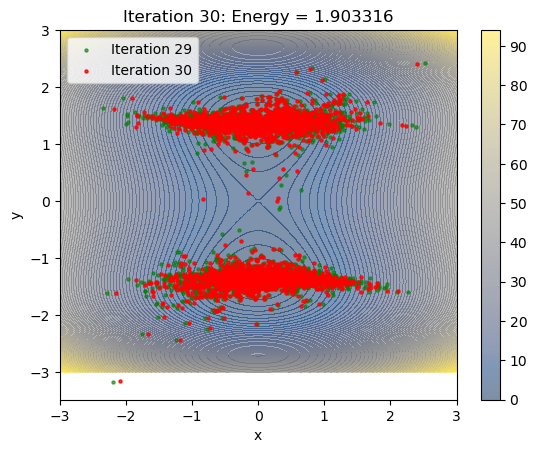

Iter  40: Energy = 1.445111, Decrease = 6.691852, Grad norm: 2.97e+00


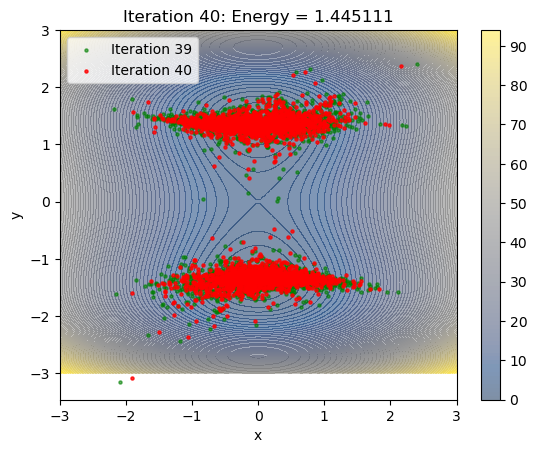

Iter  50: Energy = 1.287046, Decrease = 6.849917, Grad norm: 2.75e+00


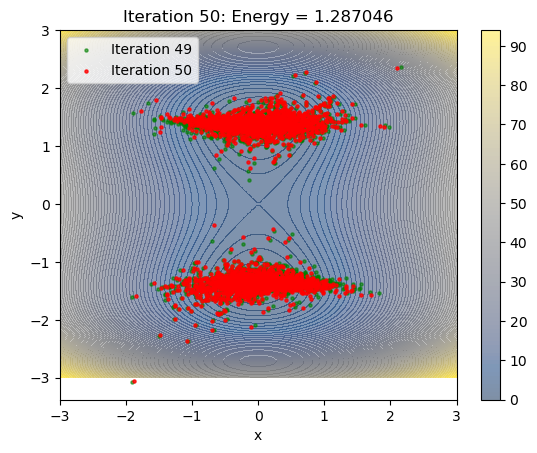

Iter  60: Energy = 1.103573, Decrease = 7.033390, Grad norm: 2.72e+00


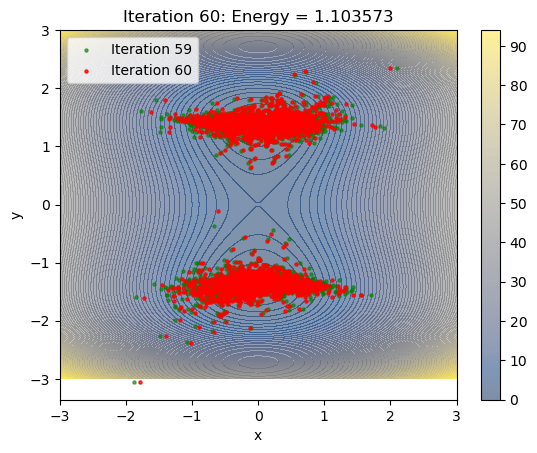

Iter  70: Energy = 0.967206, Decrease = 7.169756, Grad norm: 2.38e+00


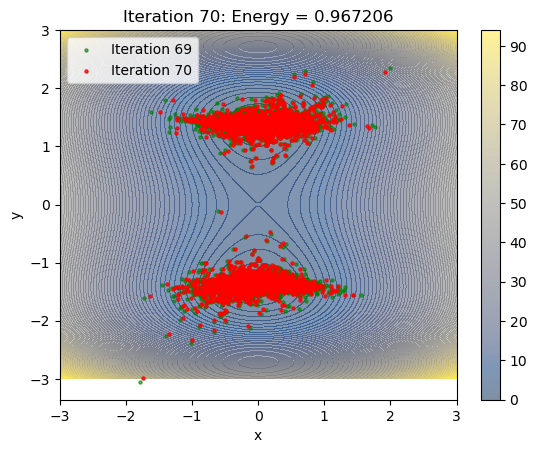

Iter  80: Energy = 0.861164, Decrease = 7.275799, Grad norm: 2.09e+00


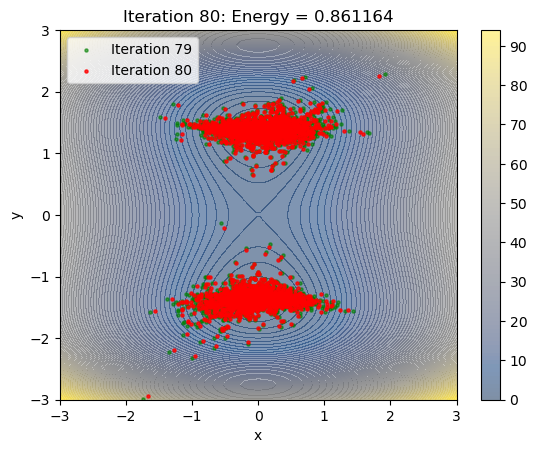

Iter  90: Energy = 0.785181, Decrease = 7.351782, Grad norm: 2.16e+00


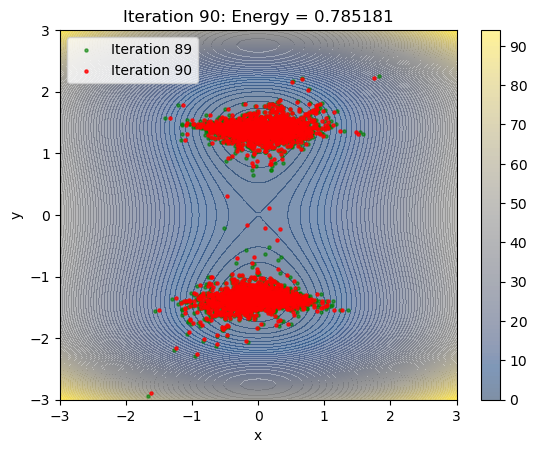


=== Integration Complete ===
Total iterations:    101
Initial energy:      8.136963
Final energy:        0.680249
Total decrease:      7.456714
Reduction ratio:     0.0836
Final param norm:    6.629053


In [26]:

results = run_gradient_flow(
    gradient_flow_node, z_samples, G_mat_flow,
    potential,solver=solver,
    h=h, max_iterations=max_iterations, tolerance=tolerance
)

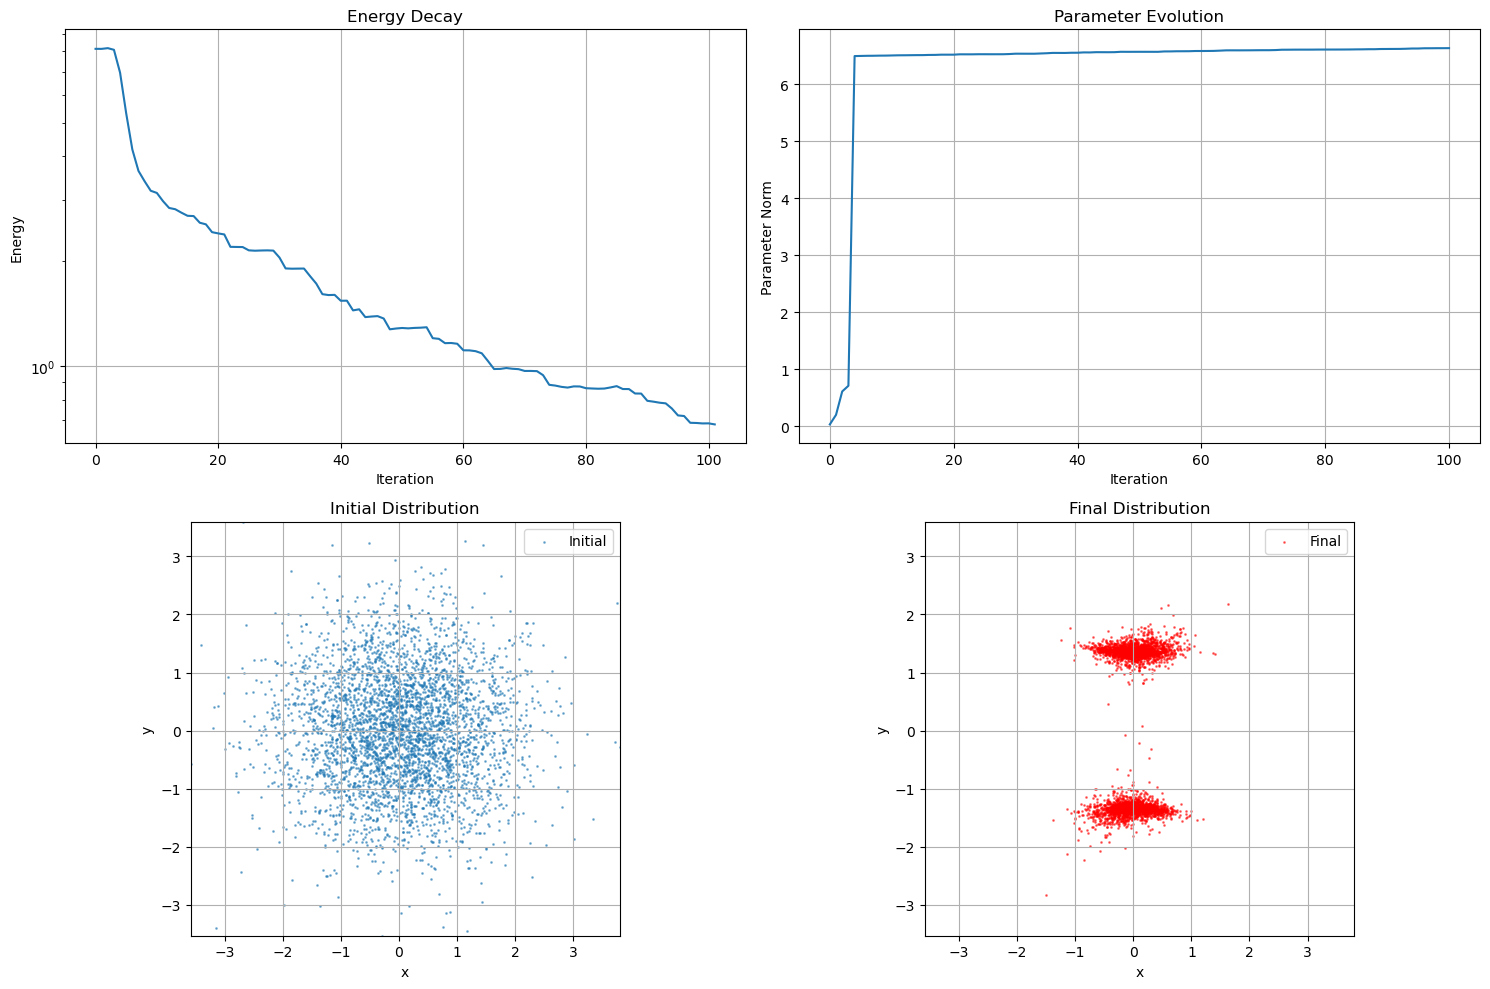

In [27]:
# Visualize results
visualize_gradient_flow_results(results)